# Active Learning

In [40]:
# !pip install modAL-python
# !pip install category_encoders
# !pip install xgboost

In [41]:
import pandas as pd
import matplotlib.pyplot as plt
import category_encoders as ce
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from modal.models import ActiveLearner, Committee
from sklearn.metrics import accuracy_score
from modal.uncertainty import uncertainty_sampling



# Read dataset
df = pd.read_csv('Dataset-vf.csv', sep=',', header=0)

# Display dataset
display(df)

,X5,X2,X3,X4,X6,X1,X10,X7,X8,X9,X11,X12,X15,X13,X14,Y
0,43,59.0,11,120,150,2709,2114,228,217,120,0.66,269,R1,FC11,CA49,BMW
1,0,54.0,7,0,693,2802,162,224,225,136,0.35,195,NaN,FC11,CA50,BMW
2,0,28.0,12,0,1260,2325,162,215,213,133,0.89,750,NaN,FC14,CA26,Mercedes
3,16,112.0,8,272,3649,2837,6221,235,231,128,0.27,-155,NaN,FC11,CA32,Ford
4,10,59.0,7,134,900,2509,5184,226,226,134,0.93,88,NaN,FC11,CA38,BMW
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6119,14,NaN,18,67,918,2712,1922,201,254,183,0.00,-877,NaN,FC13,CA24,Toyota
6120,1,67.0,6,170,824,3101,1657,227,228,135,0.50,437,NaN,FC11,CA43,Toyota
6121,-3,139.0,13,30,3127,3050,5770,240,235,123,0.74,53,NaN,FC11,CA40,Toyota
6122,12,106.0,24,30,582,2080,108,252,202,64,0.88,-79,NaN,FC14,CA23,Mercedes


In [42]:
# Get nan statistics
print(df.isnull().sum())


X5        0
X2      604
X3        0
X4        0
X6        0
X1        0
X10       0
X7        0
X8        0
X9        0
X11       0
X12       0
X15    5523
X13       0
X14       0
Y         0
dtype: int64


In [43]:
# drop column X15
df = df.drop(['X15'], axis=1)

# interpolate nan values in X2
df['X2'] = df['X2'].interpolate(method='linear')

# Display dataset
display(df)

# Get nan statistics
print(df.isnull().sum())

,X5,X2,X3,X4,X6,X1,X10,X7,X8,X9,X11,X12,X13,X14,Y
0,43,59.0,11,120,150,2709,2114,228,217,120,0.66,269,FC11,CA49,BMW
1,0,54.0,7,0,693,2802,162,224,225,136,0.35,195,FC11,CA50,BMW
2,0,28.0,12,0,1260,2325,162,215,213,133,0.89,750,FC14,CA26,Mercedes
3,16,112.0,8,272,3649,2837,6221,235,231,128,0.27,-155,FC11,CA32,Ford
4,10,59.0,7,134,900,2509,5184,226,226,134,0.93,88,FC11,CA38,BMW
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6119,14,60.0,18,67,918,2712,1922,201,254,183,0.00,-877,FC13,CA24,Toyota
6120,1,67.0,6,170,824,3101,1657,227,228,135,0.50,437,FC11,CA43,Toyota
6121,-3,139.0,13,30,3127,3050,5770,240,235,123,0.74,53,FC11,CA40,Toyota
6122,12,106.0,24,30,582,2080,108,252,202,64,0.88,-79,FC14,CA23,Mercedes


X5     0
X2     0
X3     0
X4     0
X6     0
X1     0
X10    0
X7     0
X8     0
X9     0
X11    0
X12    0
X13    0
X14    0
Y      0
dtype: int64


In [44]:
# Keep only 100 labels (Y) randomly, others are nan
df['Y'] = df['Y'].sample(n=100, random_state=1)
# df['Y'] = df['Y'].where(df['Y'].sample(n=100, random_state=1).index.isin(df['Y'].sample(n=100, random_state=1).index), np.nan)

# Display dataset
display(df)

# Get nan statistics
print(df.isnull().sum())
print()

# how many non-nan values in Y
print("Number of labeled data: ", df['Y'].count())

,X5,X2,X3,X4,X6,X1,X10,X7,X8,X9,X11,X12,X13,X14,Y
0,43,59.0,11,120,150,2709,2114,228,217,120,0.66,269,FC11,CA49,NaN
1,0,54.0,7,0,693,2802,162,224,225,136,0.35,195,FC11,CA50,NaN
2,0,28.0,12,0,1260,2325,162,215,213,133,0.89,750,FC14,CA26,NaN
3,16,112.0,8,272,3649,2837,6221,235,231,128,0.27,-155,FC11,CA32,NaN
4,10,59.0,7,134,900,2509,5184,226,226,134,0.93,88,FC11,CA38,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6119,14,60.0,18,67,918,2712,1922,201,254,183,0.00,-877,FC13,CA24,NaN
6120,1,67.0,6,170,824,3101,1657,227,228,135,0.50,437,FC11,CA43,NaN
6121,-3,139.0,13,30,3127,3050,5770,240,235,123,0.74,53,FC11,CA40,NaN
6122,12,106.0,24,30,582,2080,108,252,202,64,0.88,-79,FC14,CA23,NaN


X5        0
X2        0
X3        0
X4        0
X6        0
X1        0
X10       0
X7        0
X8        0
X9        0
X11       0
X12       0
X13       0
X14       0
Y      6024
dtype: int64

Number of labeled data:  100


In [45]:
# get unique values of all columns
for col in df.columns[-3:]:
    print(col, df[col].unique())

X13 [' FC11' ' FC14' ' FC13' ' FC12']
X14 [' CA49' ' CA50' ' CA26' ' CA32' ' CA38' ' CA42' ' CA37' ' CA23' ' CA24'
 ' CA21' ' CA43' ' CA22' ' CA36' ' CA33' ' CA44' ' CA59' ' CA30' ' CA51'
 ' CA52' ' CA31' ' CA40' ' CA58' ' CA25' ' CA39' ' CA53' ' CA60' ' CA46'
 ' CA34' ' CA41' ' CA48' ' CA54' ' CA55']
Y [nan 'Mercedes' 'GMC' 'BMW' 'Toyota' 'Honda' 'Ford']


In [46]:
df_labeled = df.dropna()
df_unlabeled = df[df['Y'].isnull()]

# Display dataset
display(df_labeled)
display(df_unlabeled)

,X5,X2,X3,X4,X6,X1,X10,X7,X8,X9,X11,X12,X13,X14,Y
28,130,167.0,18,361,1195,2311,1168,232,244,135,0.61,727,FC14,CA26,Mercedes
147,2,352.0,5,30,2713,3366,2298,211,231,158,0.36,211,FC11,CA58,GMC
200,87,179.5,11,256,755,2566,1332,193,228,175,0.51,-149,FC13,CA31,BMW
234,85,92.0,34,182,240,2787,2613,249,168,18,0.06,423,FC11,CA50,BMW
354,55,168.0,24,190,390,2910,949,231,241,127,0.62,290,FC13,CA33,BMW
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5845,0,187.0,20,0,1140,2154,918,218,250,157,0.96,393,FC14,CA37,Mercedes
5878,52,319.0,16,216,1691,2768,1128,176,224,187,0.57,816,FC13,CA31,BMW
5888,49,51.0,23,306,350,2091,631,224,184,82,0.51,584,FC14,CA21,Honda
5950,22,103.5,14,85,4414,3030,408,238,215,106,0.56,686,FC11,CA50,Toyota


,X5,X2,X3,X4,X6,X1,X10,X7,X8,X9,X11,X12,X13,X14,Y
0,43,59.0,11,120,150,2709,2114,228,217,120,0.66,269,FC11,CA49,NaN
1,0,54.0,7,0,693,2802,162,224,225,136,0.35,195,FC11,CA50,NaN
2,0,28.0,12,0,1260,2325,162,215,213,133,0.89,750,FC14,CA26,NaN
3,16,112.0,8,272,3649,2837,6221,235,231,128,0.27,-155,FC11,CA32,NaN
4,10,59.0,7,134,900,2509,5184,226,226,134,0.93,88,FC11,CA38,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6119,14,60.0,18,67,918,2712,1922,201,254,183,0.00,-877,FC13,CA24,NaN
6120,1,67.0,6,170,824,3101,1657,227,228,135,0.50,437,FC11,CA43,NaN
6121,-3,139.0,13,30,3127,3050,5770,240,235,123,0.74,53,FC11,CA40,NaN
6122,12,106.0,24,30,582,2080,108,252,202,64,0.88,-79,FC14,CA23,NaN


In [47]:
# one hot encoding for X13 and Y

df = pd.get_dummies(df, columns=['X13', 'Y'])

# binary encoding for X14
encoder = ce.BinaryEncoder(cols=['X14'])
df = encoder.fit_transform(df)

# Display dataset
display(df.columns)

Index(['X5', 'X2', 'X3', 'X4', 'X6', 'X1', 'X10', 'X7', 'X8', 'X9', 'X11',
       'X12', 'X14_0', 'X14_1', 'X14_2', 'X14_3', 'X14_4', 'X14_5',
       'X13_ FC11', 'X13_ FC12', 'X13_ FC13', 'X13_ FC14', 'Y_BMW', 'Y_Ford',
       'Y_GMC', 'Y_Honda', 'Y_Mercedes', 'Y_Toyota'],
      dtype='object')

In [48]:
# get the labeled and unlabeled data from the dataset df by indices from df_labeled and df_unlabeled
df_labeled = df.iloc[df_labeled.index]
df_unlabeled = df.iloc[df_unlabeled.index]

# Display dataset
display(df_labeled)
display(df_unlabeled)

,X5,X2,X3,X4,X6,X1,X10,X7,X8,X9,...,X13_ FC11,X13_ FC12,X13_ FC13,X13_ FC14,Y_BMW,Y_Ford,Y_GMC,Y_Honda,Y_Mercedes,Y_Toyota
28,130,167.0,18,361,1195,2311,1168,232,244,135,...,False,False,False,True,False,False,False,False,True,False
147,2,352.0,5,30,2713,3366,2298,211,231,158,...,True,False,False,False,False,False,True,False,False,False
200,87,179.5,11,256,755,2566,1332,193,228,175,...,False,False,True,False,True,False,False,False,False,False
234,85,92.0,34,182,240,2787,2613,249,168,18,...,True,False,False,False,True,False,False,False,False,False
354,55,168.0,24,190,390,2910,949,231,241,127,...,False,False,True,False,True,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5845,0,187.0,20,0,1140,2154,918,218,250,157,...,False,False,False,True,False,False,False,False,True,False
5878,52,319.0,16,216,1691,2768,1128,176,224,187,...,False,False,True,False,True,False,False,False,False,False
5888,49,51.0,23,306,350,2091,631,224,184,82,...,False,False,False,True,False,False,False,True,False,False
5950,22,103.5,14,85,4414,3030,408,238,215,106,...,True,False,False,False,False,False,False,False,False,True


,X5,X2,X3,X4,X6,X1,X10,X7,X8,X9,...,X13_ FC11,X13_ FC12,X13_ FC13,X13_ FC14,Y_BMW,Y_Ford,Y_GMC,Y_Honda,Y_Mercedes,Y_Toyota
0,43,59.0,11,120,150,2709,2114,228,217,120,...,True,False,False,False,False,False,False,False,False,False
1,0,54.0,7,0,693,2802,162,224,225,136,...,True,False,False,False,False,False,False,False,False,False
2,0,28.0,12,0,1260,2325,162,215,213,133,...,False,False,False,True,False,False,False,False,False,False
3,16,112.0,8,272,3649,2837,6221,235,231,128,...,True,False,False,False,False,False,False,False,False,False
4,10,59.0,7,134,900,2509,5184,226,226,134,...,True,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6119,14,60.0,18,67,918,2712,1922,201,254,183,...,False,False,True,False,False,False,False,False,False,False
6120,1,67.0,6,170,824,3101,1657,227,228,135,...,True,False,False,False,False,False,False,False,False,False
6121,-3,139.0,13,30,3127,3050,5770,240,235,123,...,True,False,False,False,False,False,False,False,False,False
6122,12,106.0,24,30,582,2080,108,252,202,64,...,False,False,False,True,False,False,False,False,False,False


In [81]:
# split dataset into train and test and validate
df_labeled_train, df_labeled_test = train_test_split(df_labeled, test_size=0.2, random_state=1)
df_labeled_train, df_labeled_validate = train_test_split(df_labeled_train, test_size=0.2, random_state=1)

# split data into X and Y
X_train = df_labeled_train.iloc[:, :-6]
y_train = df_labeled_train.iloc[:, -6:]

X_test = df_labeled_test.iloc[:, :-6]
y_test = df_labeled_test.iloc[:, -6:]

X_validate = df_labeled_validate.iloc[:, :-6]
y_validate = df_labeled_validate.iloc[:, -6:]

X_unlabeled = df_unlabeled.iloc[:, :-6]
y_unlabeled = df_unlabeled.iloc[:, -6:]


# Display dataset
print("train data: ", X_train.shape, y_train.shape)
print("test data: ", X_test.shape, y_test.shape)
print("validate data: ", X_validate.shape, y_validate.shape)

display(X_train)
display(y_train)


train data:  (64, 22) (64, 6)
test data:  (20, 22) (20, 6)
validate data:  (16, 22) (16, 6)


,X5,X2,X3,X4,X6,X1,X10,X7,X8,X9,...,X14_0,X14_1,X14_2,X14_3,X14_4,X14_5,X13_ FC11,X13_ FC12,X13_ FC13,X13_ FC14
234,85,92.0,34,182,240,2787,2613,249,168,18,...,0,0,0,0,1,0,True,False,False,False
5888,49,51.0,23,306,350,2091,631,224,184,82,...,0,0,1,0,1,0,False,False,False,True
3039,23,58.0,4,283,150,2722,834,223,230,143,...,0,1,0,1,0,0,False,False,True,False
354,55,168.0,24,190,390,2910,949,231,241,127,...,0,0,1,1,1,0,False,False,True,False
5407,-39,54.0,6,495,700,2600,732,224,227,138,...,0,0,0,1,1,1,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4451,81,164.0,18,234,726,2535,912,233,243,133,...,0,0,1,0,0,1,False,False,True,False
2440,184,147.0,27,350,1958,2935,808,244,226,93,...,0,0,1,1,1,0,False,False,True,False
3782,0,108.0,2,0,865,2055,256,221,237,151,...,0,0,1,0,1,0,False,False,False,True
3206,0,27.0,17,0,882,2240,1150,211,202,123,...,0,1,0,0,0,1,False,False,False,True


,Y_BMW,Y_Ford,Y_GMC,Y_Honda,Y_Mercedes,Y_Toyota
234,True,False,False,False,False,False
5888,False,False,False,True,False,False
3039,True,False,False,False,False,False
354,True,False,False,False,False,False
5407,True,False,False,False,False,False
...,...,...,...,...,...,...
4451,False,False,False,True,False,False
2440,True,False,False,False,False,False
3782,False,False,False,False,True,False
3206,False,False,False,False,True,False


## Uncertainty Sampling

In [82]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import numpy as np

# Assuming X_train, y_train, and X_unlabeled are defined
# X_train: 100 labeled instances
# y_train: Labels for the 100 labeled instances
# X_unlabeled: Unlabeled instances

# Initialize the model with the 100 labeled instances
model = RandomForestClassifier()
model.fit(X_train, y_train)

# Define the number of iterations for self-training
num_iterations = 5

for _ in range(num_iterations):
    # Predict labels for the unlabeled instances
    pseudo_labels = model.predict(X_unlabeled)

    # Add the pseudo-labeled instances to the training set
    X_train = np.vstack([X_train, X_unlabeled])
    y_train = np.concatenate([y_train, pseudo_labels])

    # Retrain the model using the expanded training set
    model.fit(X_train, y_train)

model.predict(X_test)
model.score(X_test, y_test)




c:\Python311\Lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
c:\Python311\Lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
c:\Python311\Lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
c:\Python311\Lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
c:\Python311\Lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
c:\Python311\Lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


0.85

In [89]:
# fill nan values in Y with predicted values from model
predictions = model.predict(X_unlabeled)

# re construct the dataframe
df_unlabeled.iloc[:, -6:] = predictions

df = pd.concat([df_labeled, df_unlabeled])

# Display dataset
display(df)

c:\Python311\Lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


,X5,X2,X3,X4,X6,X1,X10,X7,X8,X9,...,X13_ FC11,X13_ FC12,X13_ FC13,X13_ FC14,Y_BMW,Y_Ford,Y_GMC,Y_Honda,Y_Mercedes,Y_Toyota
28,130,167.0,18,361,1195,2311,1168,232,244,135,...,False,False,False,True,False,False,False,False,True,False
147,2,352.0,5,30,2713,3366,2298,211,231,158,...,True,False,False,False,False,False,True,False,False,False
200,87,179.5,11,256,755,2566,1332,193,228,175,...,False,False,True,False,True,False,False,False,False,False
234,85,92.0,34,182,240,2787,2613,249,168,18,...,True,False,False,False,True,False,False,False,False,False
354,55,168.0,24,190,390,2910,949,231,241,127,...,False,False,True,False,True,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6119,14,60.0,18,67,918,2712,1922,201,254,183,...,False,False,True,False,False,False,False,False,False,False
6120,1,67.0,6,170,824,3101,1657,227,228,135,...,True,False,False,False,False,False,False,False,False,False
6121,-3,139.0,13,30,3127,3050,5770,240,235,123,...,True,False,False,False,False,False,False,False,False,False
6122,12,106.0,24,30,582,2080,108,252,202,64,...,False,False,False,True,False,False,False,False,True,False


In [92]:
# !pip install xgboost
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV


In [95]:
X = df.iloc[:, :-6]
y = df.iloc[:, -6:]

# split dataset into train and test and validate
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
X_train, X_validate, y_train, y_validate = train_test_split(X_train, y_train, test_size=0.2, random_state=1)



# XGBClassifier Classifier
parameters={'n_estimators': [100, 200, 300, 400, 500], 'max_depth': [5, 10, 15, 20, 25, 30]}


#grid search for the model
grid_search = GridSearchCV(estimator=XGBClassifier(),
                        param_grid=parameters,
                        scoring='accuracy',
                        cv=10,
                        n_jobs=-1)
grid_search.fit(X_train, y_train)
best_accuracy = grid_search.best_score_
best_parameters = grid_search.best_params_
print("Best Accuracy: ",best_accuracy)
print("Parameters: ",best_parameters)
best_model = grid_search.best_estimator_







Best Accuracy:  0.912477817213842
Parameters:  {'max_depth': 10, 'n_estimators': 500}


In [96]:
#predicting the test data
y_pred = best_model.predict(X_test)


#accuracy score
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, y_pred)
print("Test Accuracy",accuracy)

#classification report
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))


#cross validation
from sklearn.model_selection import cross_val_score
accuracies = cross_val_score(estimator=best_model, X=X_train, y=y_train, cv=10)
print("Mean Accuracies: ",accuracies.mean())
print("std Accuracies: ",accuracies.std())

Test Accuracy 0.9093877551020408
              precision    recall  f1-score   support

           0       0.91      0.95      0.93       352
           1       0.00      0.00      0.00         0
           2       1.00      0.25      0.40         4
           3       0.93      0.91      0.92       124
           4       0.96      0.96      0.96       315
           5       0.75      0.58      0.65        26

   micro avg       0.93      0.93      0.93       821
   macro avg       0.76      0.61      0.64       821
weighted avg       0.93      0.93      0.93       821
 samples avg       0.63      0.63      0.63       821



c:\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Rec

Mean Accuracies:  0.912477817213842
std Accuracies:  0.013305830745694377


## Query by Committee

Accuracy: 0.976327


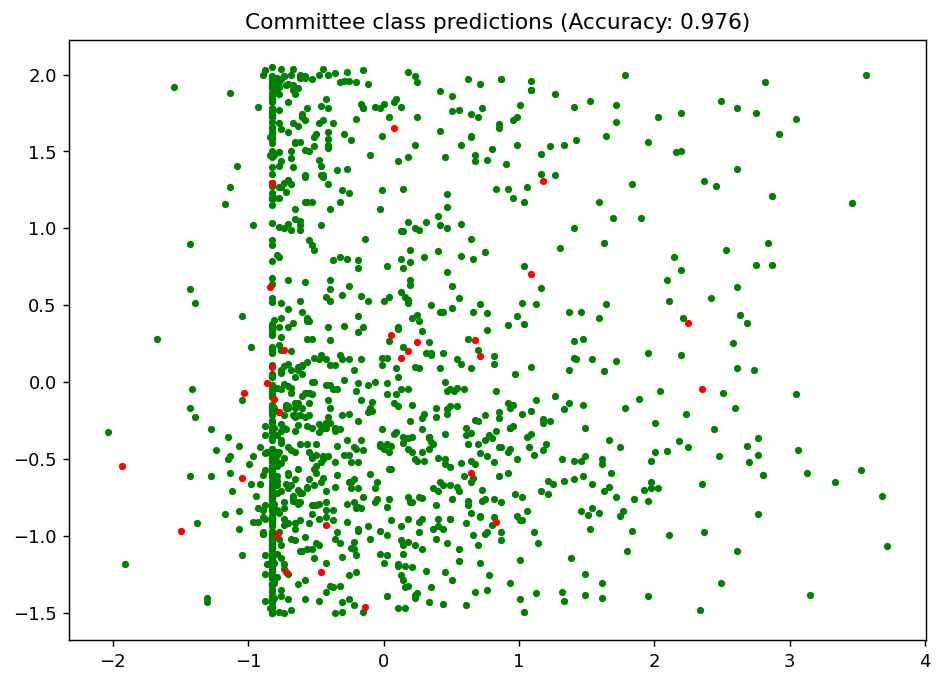

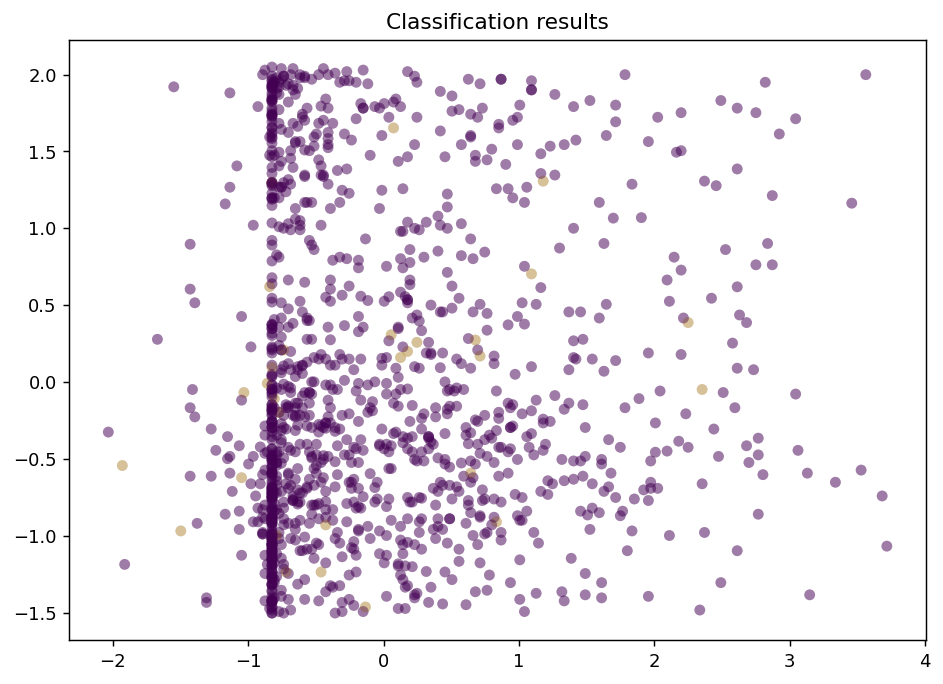

,X5,X2,X3,X4,X6,X1,X10,X7,X8,X9,...,X13_ FC11,X13_ FC12,X13_ FC13,X13_ FC14,Y_BMW,Y_Ford,Y_GMC,Y_Honda,Y_Mercedes,Y_Toyota
0,43,59.0,11,120,150,2709,2114,228,217,120,...,True,False,False,False,False,False,False,False,False,False
1,0,54.0,7,0,693,2802,162,224,225,136,...,True,False,False,False,False,False,False,False,False,False
2,0,28.0,12,0,1260,2325,162,215,213,133,...,False,False,False,True,False,False,False,False,False,False
3,16,112.0,8,272,3649,2837,6221,235,231,128,...,True,False,False,False,False,False,False,False,False,False
4,10,59.0,7,134,900,2509,5184,226,226,134,...,True,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6119,14,60.0,18,67,918,2712,1922,201,254,183,...,False,False,True,False,False,False,False,False,False,False
6120,1,67.0,6,170,824,3101,1657,227,228,135,...,True,False,False,False,False,False,False,False,False,False
6121,-3,139.0,13,30,3127,3050,5770,240,235,123,...,True,False,False,False,False,False,False,False,False,False
6122,12,106.0,24,30,582,2080,108,252,202,64,...,False,False,False,True,False,False,False,False,False,False


In [ ]:
# Initialize the learners
n_learners = 7
learner_list = [ActiveLearner(
    estimator=RandomForestClassifier(),
    X_training=X_train, y_training=Y_train
) for _ in range(n_learners)]

# Initialize the committee
committee = Committee(
    learner_list=learner_list, 
    # default query strategy is vote entropy sampling
    )

# Predict
Y_pred = committee.predict(X_test)

# Accuracy
from sklearn.metrics import accuracy_score
print('Accuracy: %f' % accuracy_score(Y_test, Y_pred))

# Plot the decision surface
predictions = committee.predict(X_test)
is_correct = (predictions == Y_test)

fig, ax = plt.subplots(figsize=(8.5, 6), dpi=130)
ax.scatter(X_test[is_correct, 0], X_test[is_correct, 1], c='g', marker='.', label='Correct')
ax.scatter(X_test[~is_correct, 0], X_test[~is_correct, 1], c='r', marker='.', label='Incorrect')
ax.set_title('Committee class predictions (Accuracy: {score:.3f})'.format(score=accuracy_score(Y_test, predictions)))

# Plot the classification results
fig, ax = plt.subplots(figsize=(8.5, 6), dpi=130)
ax.scatter(X_test[:, 0], X_test[:, 1], c=predictions, cmap='viridis', alpha=0.3, edgecolors='none')
ax.scatter(X_test[:, 0], X_test[:, 1], c=Y_test, cmap='viridis', alpha=0.3, edgecolors='none')
ax.set_title('Classification results')
plt.show()

display(df)


